<a id="2"></a>
# Modeling the Results of Pulls for MR Shards Using Monte Carlo Simulations
Credit to **VoidTwo** (_voidtwo on Discord_) for writing the code<br>
Report written by Nillabutt<br>
February 8, 2024

[*jump to the tables*](#1)

In [1]:
# Future imports
from __future__ import annotations

# Standard imports
from collections import defaultdict
from multiprocessing.pool import Pool as mp_Pool
from secrets import randbelow as secrets_randbelow
from typing import TYPE_CHECKING

# 3rd party imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

In [2]:
# Type checking
if TYPE_CHECKING:
    from typing import (
        ClassVar,
        Final)

    from matplotlib.axes import Axes

In [3]:
class SummonInfo:
    shard_probability_range: ClassVar[int] = 100_000
    shard_probability_threshold: ClassVar[dict[int, int]] = {
        1: 23_841,  # 23.841%
        2: 31_126,  # 7.285%
        5: 33_775}  # 2.649%
    shard_probability_order: ClassVar[tuple[int, ...]] = (
        1, 2, 5)

    shard_pities: ClassVar[dict[int, int]] = {
        1: 6,
        2: 16,
        5: 65}
    shard_pity_floors: ClassVar[dict[int, int]] = {
        1: 6,
        2: 15,
        5: 58}
    shard_pity_priority: ClassVar[tuple[int, ...]] = (
        5, 2, 1)

    shard_goal: ClassVar[int] = 270

    __slots__: tuple[str, ...] = ()

    def __init__(self) -> None:
        return


class SummonProgress:
    __slots__: tuple[str, ...] = (
        '__pity_counts',
        '__accumulated_shards')

    def __init__(self) -> None:
        shard_count: int
        self.__pity_counts: Final[dict[int, int]] = dict(
            (shard_count, 1) for shard_count in SummonInfo.shard_pity_priority)
        self.__accumulated_shards: int = 0
        return

    def __str__(self) -> str:
        return (
            f'__pity_counts: {self.__pity_counts}\n'
            f'__accumulated_shards: {self.__accumulated_shards}')

    @property
    def accumulated_shards(self) -> int:
        return self.__accumulated_shards

    def add_shards(self, shard_count: int) -> None:
        self.__accumulated_shards += shard_count
        return

    def get_pity_count(self, shard_count: int) -> int:
        return self.__pity_counts[shard_count]

    def add_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] += 1
        return

    def reset_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] = 1
        return

In [4]:
def simulate_summon(summon_progress: SummonProgress) -> None:
    add_shards: int = 0
    shard_count: int

    for shard_count in SummonInfo.shard_pity_priority:
        if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pities[shard_count]:
            summon_progress.reset_pity(shard_count)
            add_shards = shard_count
            break

    if add_shards == 0:
        random_value: int = secrets_randbelow(SummonInfo.shard_probability_range)
        threshold_expired: bool = False

        for shard_count in SummonInfo.shard_probability_order:
            if add_shards == 0 \
                    and not threshold_expired \
                    and random_value < SummonInfo.shard_probability_threshold[shard_count]:
                threshold_expired = True

                if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pity_floors[shard_count]:
                    summon_progress.reset_pity(shard_count)
                    add_shards = shard_count
                    continue

            summon_progress.add_pity(shard_count)
    else:
        for shard_count in SummonInfo.shard_pity_priority:
            if shard_count != add_shards:
                summon_progress.add_pity(shard_count)

    summon_progress.add_shards(add_shards)
    return

In [5]:
def fully_summon(_: int) -> int:
    summon_progress: SummonProgress = SummonProgress()
    summon_count: int = 0

    while summon_progress.accumulated_shards < SummonInfo.shard_goal:
        simulate_summon(summon_progress)
        summon_count += 1
        # print(f'Summon #{summon_count}: {summon_progress.accumulated_shards}')
    return summon_count

In [6]:
def blues(target) -> None:
    SummonInfo.shard_goal = target
    iterations: Final[int] = 20000
    results: defaultdict = defaultdict(int)
    pool: mp_Pool
    summon_count: int

    for summon_count in map(fully_summon, range(iterations)):
        results[summon_count] += 1

    result_summon_counts: list[int] = []
    result_summon_count_counts: list[int] = []
    summon_count_count: int

    for summon_count, summon_count_count in sorted(results.items()):
        result_summon_counts.append(summon_count)
        result_summon_count_counts.append(summon_count_count)
    
    cmap = plt.get_cmap('gist_rainbow')
    
    results_df: DataFrame = pd.DataFrame({'Blue Scrolls': result_summon_counts, 'Likelihood': result_summon_count_counts})
    color_length = len(results_df['Blue Scrolls'])
    result_ax: Axes = results_df.plot.bar(x='Blue Scrolls', y='Likelihood', legend=None, color=cmap(np.linspace(0,0.4,color_length)))
    
    plt.title(f"Probability Distribution of Pulls for {target} MR Shards")
    plt.show()
    print(results_df)
    blue_max = results_df["Blue Scrolls"].max()
    blue_min = results_df["Blue Scrolls"].min()
    results_df["Weighted"] = results_df["Likelihood"] * results_df["Blue Scrolls"]
    average_blues = results_df["Weighted"].sum() / iterations
    blue_freq_max = results_df["Likelihood"].max()
    blue_mode = results_df.loc[results_df["Likelihood"] == blue_freq_max, "Blue Scrolls"].iloc[0]
    print(F"Iterations: {iterations}")
    print(f"Min:  {blue_min} blues")
    print(f"Max:  {blue_max} blues")
    print(f"Mean: {average_blues} blues")
    print(f"Mode: {blue_mode} blues")
    return

<a id="1"></a>
# Running the Simulations (20,000 iterations)

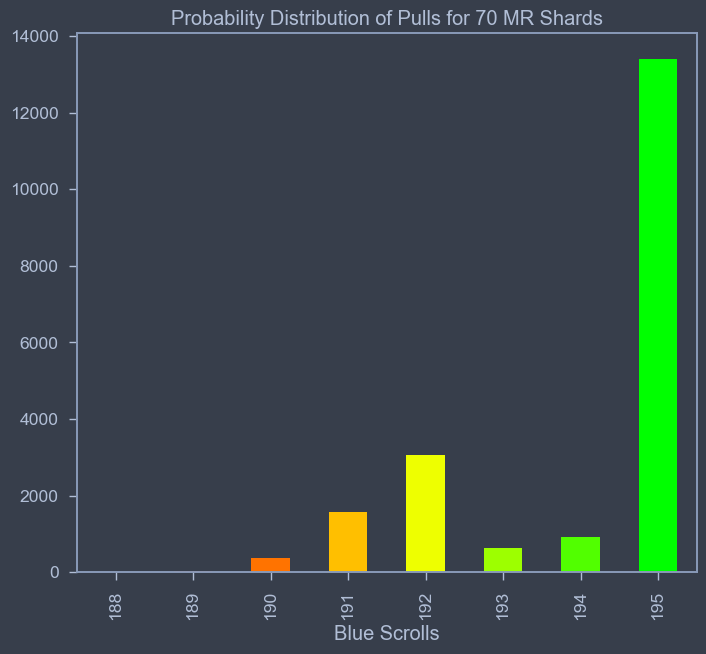

   Blue Scrolls  Likelihood
0           188           2
1           189          39
2           190         370
3           191        1576
4           192        3063
5           193         636
6           194         909
7           195       13405
Iterations: 20000
Min:  188 blues
Max:  195 blues
Mean: 194.0114 blues
Mode: 195 blues


In [7]:
# Blues for 70 shards (0 star)
blues(70)

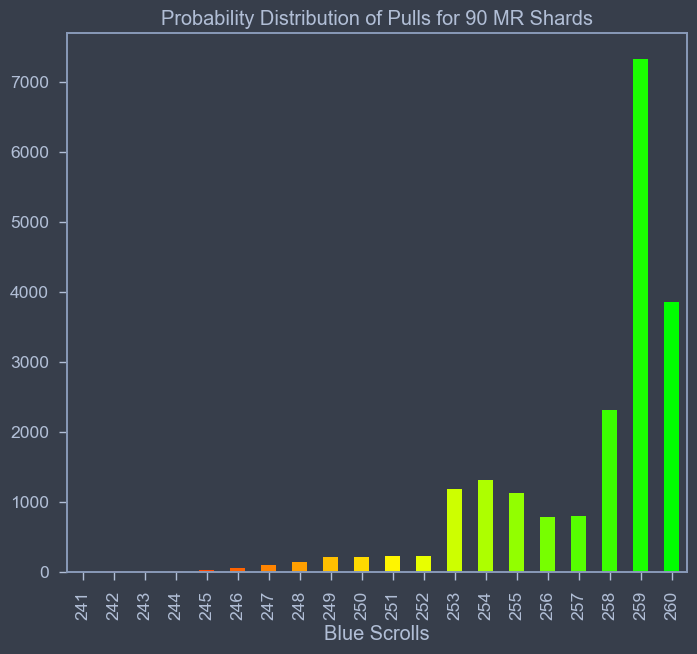

    Blue Scrolls  Likelihood
0            241           2
1            242          14
2            243          19
3            244          14
4            245          25
5            246          61
6            247         104
7            248         151
8            249         218
9            250         223
10           251         224
11           252         226
12           253        1191
13           254        1321
14           255        1131
15           256         785
16           257         803
17           258        2315
18           259        7325
19           260        3848
Iterations: 20000
Min:  241 blues
Max:  260 blues
Mean: 257.3448 blues
Mode: 259 blues


In [8]:
# Blues for 90 shards (1 star)
blues(90)

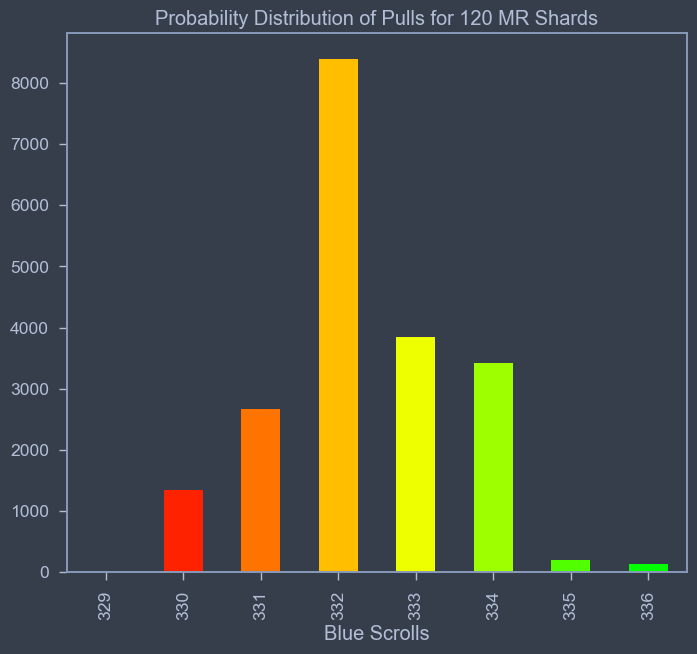

   Blue Scrolls  Likelihood
0           329           1
1           330        1337
2           331        2669
3           332        8395
4           333        3848
5           334        3426
6           335         198
7           336         126
Iterations: 20000
Min:  329 blues
Max:  336 blues
Mean: 332.3226 blues
Mode: 332 blues


In [9]:
# Blues for 120 shards (2 star)
blues(120)

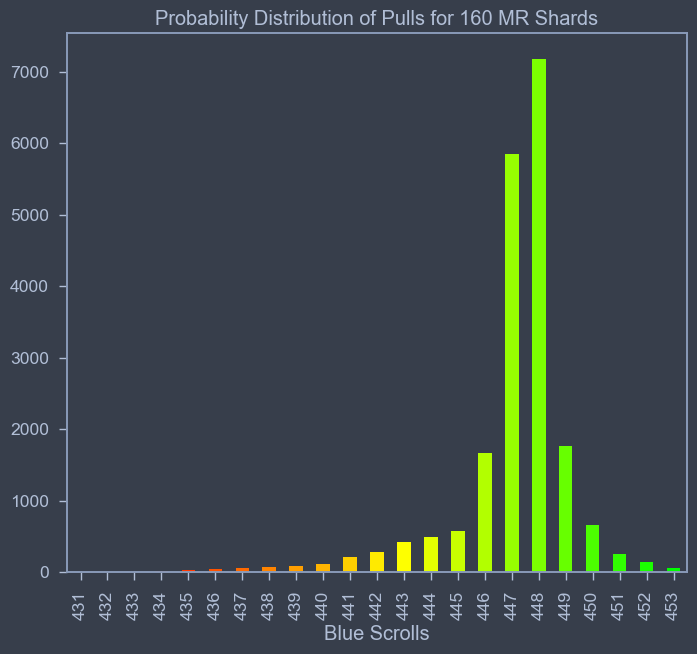

    Blue Scrolls  Likelihood
0            431           3
1            432           8
2            433           5
3            434           9
4            435          26
5            436          45
6            437          64
7            438          77
8            439          89
9            440         107
10           441         216
11           442         285
12           443         417
13           444         490
14           445         578
15           446        1672
16           447        5844
17           448        7180
18           449        1770
19           450         664
20           451         259
21           452         139
22           453          53
Iterations: 20000
Min:  431 blues
Max:  453 blues
Mean: 447.1059 blues
Mode: 448 blues


In [10]:
# Blues for 160 shards (3 star)
blues(160)

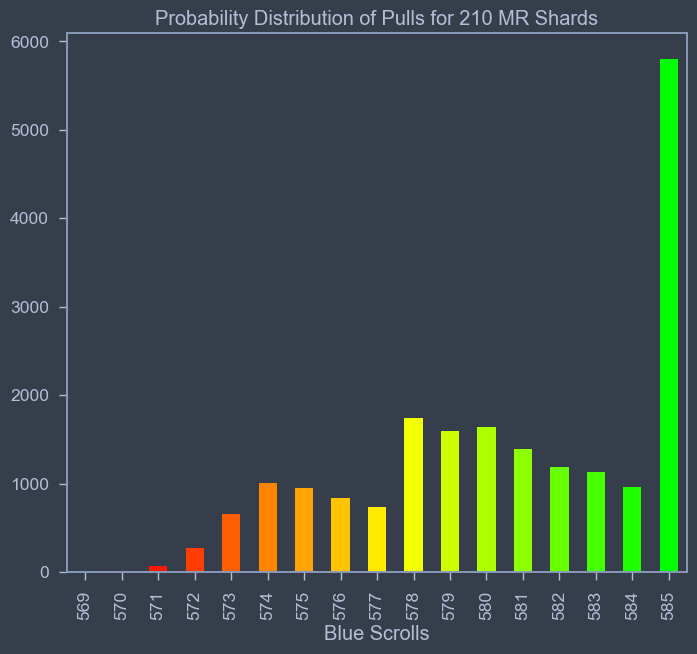

    Blue Scrolls  Likelihood
0            569           2
1            570          10
2            571          70
3            572         268
4            573         656
5            574        1006
6            575         952
7            576         833
8            577         742
9            578        1745
10           579        1592
11           580        1641
12           581        1394
13           582        1187
14           583        1132
15           584         967
16           585        5803
Iterations: 20000
Min:  569 blues
Max:  585 blues
Mean: 580.55615 blues
Mode: 585 blues


In [11]:
# Blues for 210 shards (4 star)
blues(210)

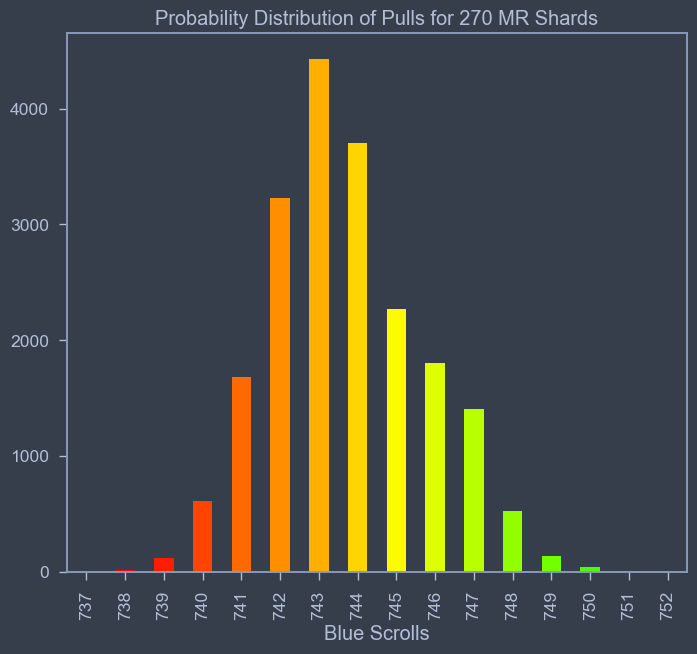

    Blue Scrolls  Likelihood
0            737           1
1            738          17
2            739         124
3            740         614
4            741        1686
5            742        3228
6            743        4429
7            744        3706
8            745        2273
9            746        1801
10           747        1404
11           748         527
12           749         137
13           750          43
14           751           8
15           752           2
Iterations: 20000
Min:  737 blues
Max:  752 blues
Mean: 743.7041 blues
Mode: 743 blues


In [12]:
# Blues for 270 shards (5 star)
blues(270)

[*Back to Top*](#2)